In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from tqdm import tqdm
from tempfile import TemporaryDirectory
import imageio

In [3]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [4]:
import sys
sys.path.append("..")

In [5]:
# Import the model we'll be using here
from sva.models.gp import EasyMultiTaskGP

# Import the various experiments we need for the notebook
from sva.experiments import Sine2Phase2Resolutions

# Import the value function
from sva.value import SVF

torch default dtype set to torch.float64


/Users/mc/miniforge3/envs/py3.11-sva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A simple 2d example

In [6]:
experiment = Sine2Phase2Resolutions()

In [7]:
experiment.initialize_data(n=3, protocol="random", seed=123)
extent = experiment.get_experimental_domain_mpl_extent()

In [8]:
# Get the ground truth results
x = experiment.get_dense_coordinates(ppd=20)
y = experiment(x)
x2 = experiment.get_dense_coordinates(ppd=20, modality=1)
y2 = experiment(x2)
extent = experiment.get_experimental_domain_mpl_extent()

First, let's look at the "correct" value landscape generated by the ground truth.

In [9]:
svf = SVF()
value = svf(x, y)
value2 = svf(x2, y2)

In [10]:
grid = np.linspace(0, 1, 100)
b = 0.5 + 0.25 * np.sin(2.0 * np.pi * grid)

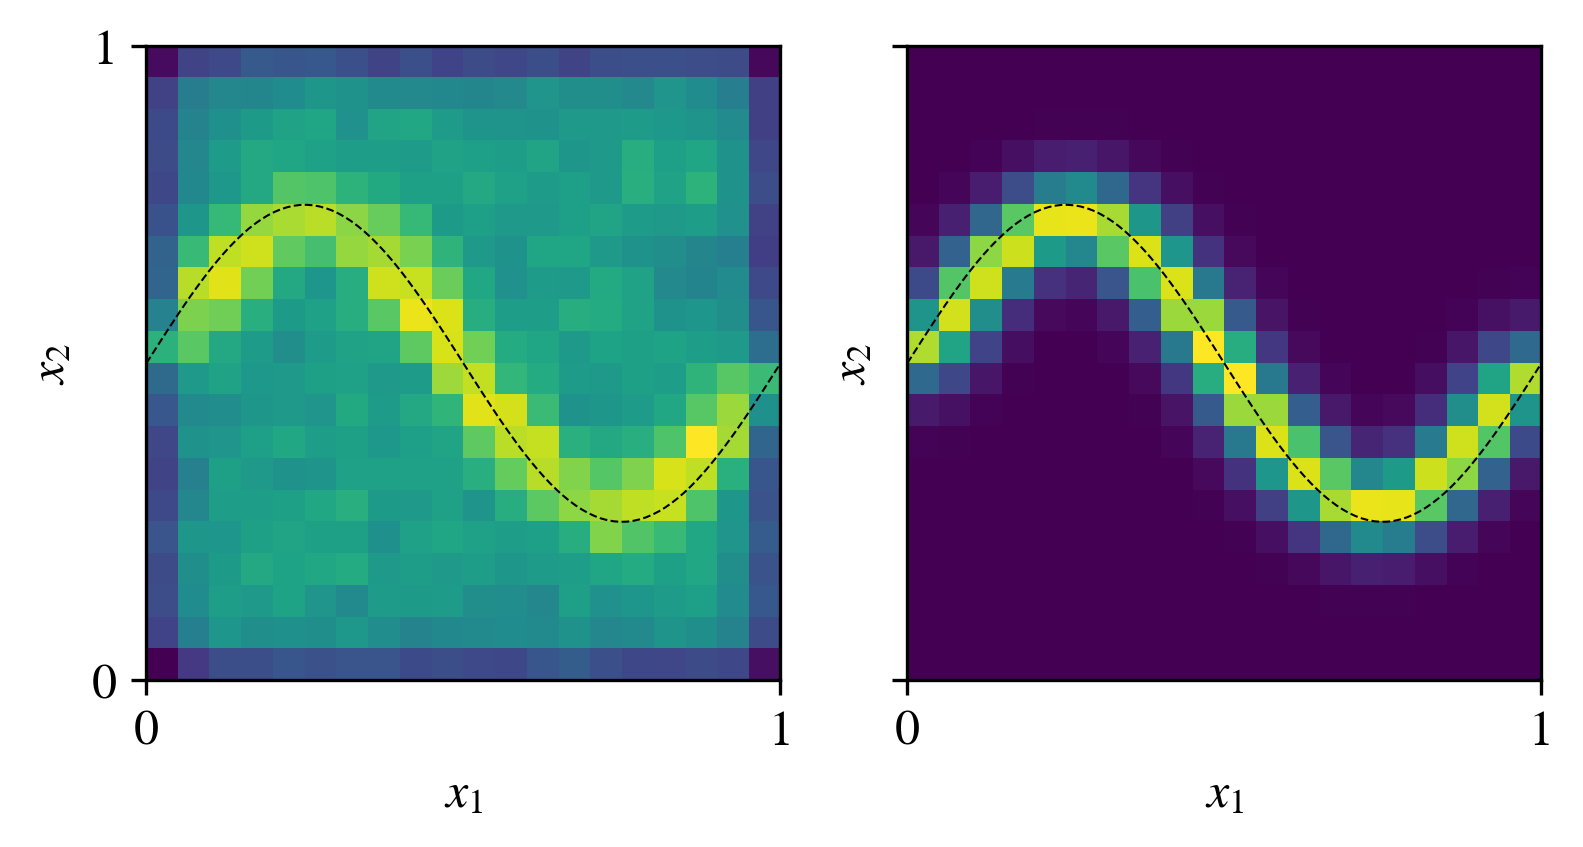

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
        
ax = axs[0]
im = ax.imshow(value.reshape(20, 20).T, extent=extent, interpolation='nearest', origin='lower')
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

ax = axs[1]
im = ax.imshow(value2.reshape(20, 20).T, extent=extent, interpolation='nearest', origin='lower')
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

for ax in axs:
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

plt.show()

There clearly is a significant amount of information contained in the more noisy, low-resolution data, but it's not nearly as well resolved as the high-resolution, expensive experiment. Can we use one experiment to inform the other? Let's give it a try using the multi-output (task) GP.

In [71]:
# We'll use a dense grid for the low-resolution experiment
x = experiment.get_dense_coordinates(ppd=20)

# We'll use just a bunch of random points for the high-resolution experiment
x2 = experiment.get_random_coordinates(n=2, modality=1, seed=123)

# Concatenate these inputs for training
x_train = np.concatenate([x, x2], axis=0)

# Create the value for each of these
y = svf(x, experiment(x))
y2 = svf(x2, experiment(x2))

# And concatenate those for training
y_train = np.concatenate([y, y2]).reshape(-1, 1)

In [72]:
gp = EasyMultiTaskGP.from_default(x_train, y_train)

In [73]:
gp.fit_mll()

{'elapsed': 0.858157167036552}

In [74]:
# Predict on a very dense grid
x_pred = experiment.get_dense_coordinates(ppd=100, modality=0)
x2_pred = experiment.get_dense_coordinates(ppd=100, modality=1)

In [75]:
mu, var = gp.predict(x_pred, observation_noise=False)
mu2, var2 = gp.predict(x2_pred, observation_noise=False)

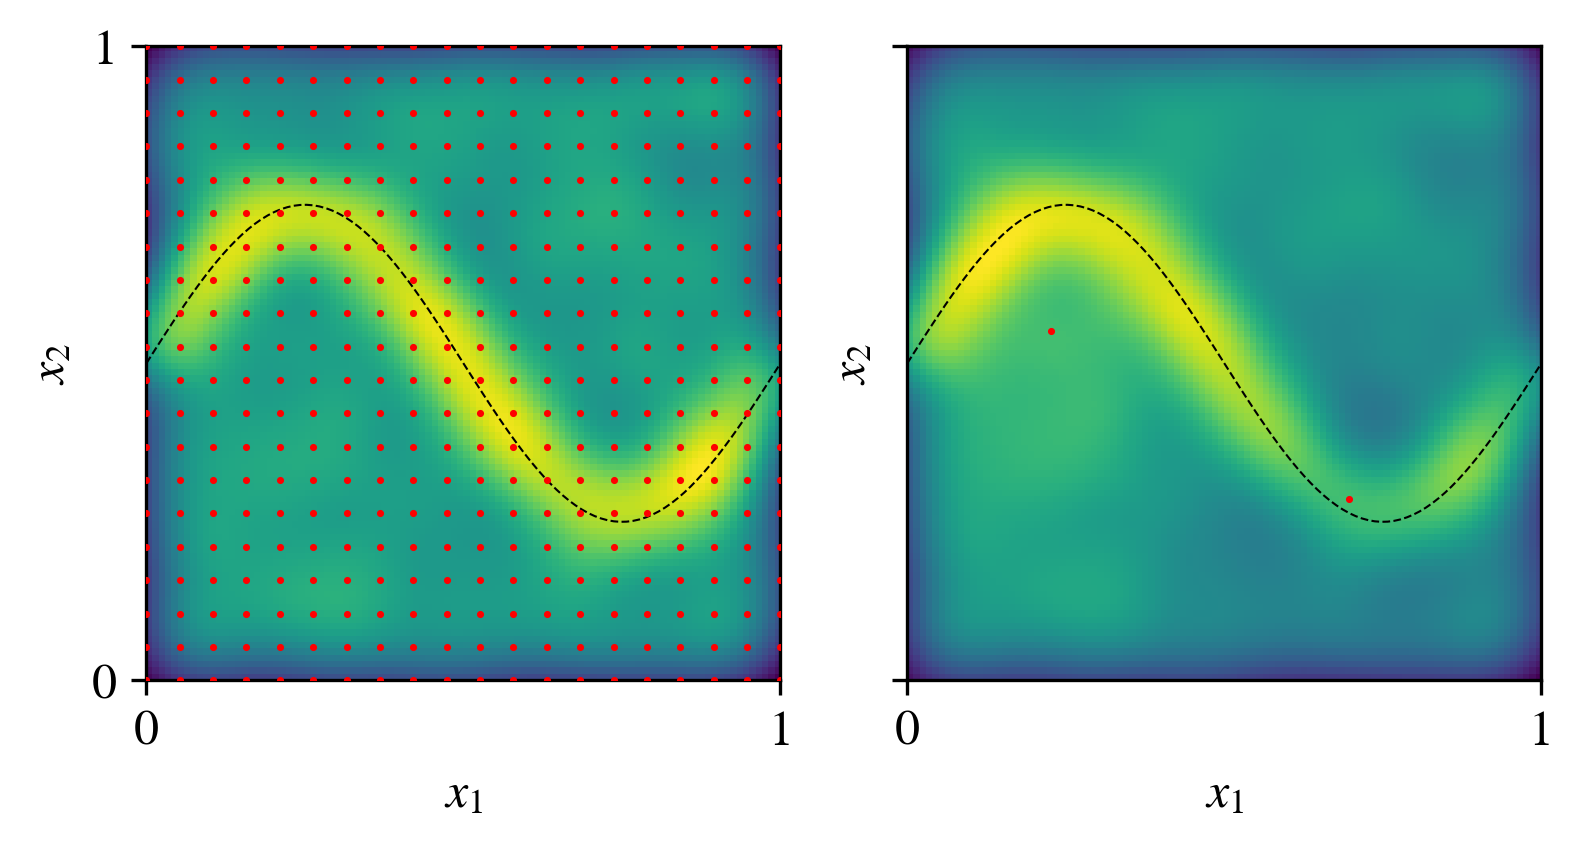

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
        
ax = axs[0]
im = ax.imshow(mu.reshape(100, 100).T, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(x[:, 0], x[:, 1], color="red", s=0.5, zorder=3)
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

ax = axs[1]
im = ax.imshow(mu2.reshape(100, 100).T, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(x2[:, 0], x2[:, 1], color="red", s=0.5, zorder=3)
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

for ax in axs:
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

plt.show()

In [14]:
def modality_callback(index):

    # Run expensive experiment every 10
    if index != 0 and index % 10 == 0:
        return 1
    return 0

In [ ]:
value = svf(X, experiment(X)).reshape(-1, 1)

In [ ]:
# Train a GP on the current data
gp = EasySingleTaskGP.from_default(X, value)
gp.fit_mll()
mu, var = gp.predict(x)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2), sharex=True, sharey=True)

ax = axs
ax.imshow(mu.reshape(100, 100).T, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(X[:, 0], X[:, 1], color="black", s=0.5)

plt.show()

# Running the experiment (short version)

In [ ]:
svf = SVF()
experiment = Sine2Phase()
experiment.initialize_data(n=3, protocol="random", seed=123)
extent = experiment.get_experimental_domain_mpl_extent()

In [ ]:
x = experiment.get_dense_coordinates(ppd=100)
y = experiment(x)

In [ ]:
experiment.run_gp_experiment(150, svf=svf)

In [ ]:
grid = np.linspace(0, 1, 100)
b = 0.5 + 0.25 * np.sin(2.0 * np.pi * grid)

In [ ]:
gp = experiment.data.history[-1]["easy_gp"]
mu, var = gp.predict(x)
mu = mu.reshape(100, 100).T
mu -= mu.min()
mu /= mu.max()
var = var.reshape(100, 100).T
var -= var.min()
var /= var.max()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2), sharex=True, sharey=True)

ax = axs

X = experiment.data.X
im = ax.imshow(mu, extent=extent, interpolation='nearest', origin='lower')
ax.scatter(X[:, 0], X[:, 1], color="red", s=0.5, zorder=3)
ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.show()

## Let's make a GIF of the mean

In [ ]:
with TemporaryDirectory() as f:

    filenames = []

    for ii, datum in tqdm(enumerate(experiment.data.history)):

        gp = datum["easy_gp"]
        mu, var = gp.predict(x)
        mu = mu.reshape(100, 100).T
        mu -= mu.min()
        mu /= mu.max()
    
        fig, axs = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
        
        ax = axs
    
        n = ii + 3
        im = ax.imshow(mu, extent=extent, interpolation='nearest', origin='lower')
        ax.scatter(X[:n, 0], X[:n, 1], color="red", s=0.5, zorder=3)
        ax.plot(grid, b, linestyle="--", linewidth=0.5, color="black")
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
    
        ax.set_title(f"$N={n}$")
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_label(r"$\mathcal{G}(\mathbf{x}) \approx U_i(D_N)$")

        filename = f'{f}/{ii}.png'
        filenames.append(filename)

        plt.savefig(filename)
        plt.close()
    
    frames = []
    for filename in filenames:
        frames.append(imageio.imread(filename))
        
    exportname = "sine2phase.gif"
    kwargs = { 'duration': 1.0 }
    imageio.mimsave(exportname, frames, 'GIF', **kwargs)